## Neural network for solving 2D poission equation
SA-PINN example calculating the electrostatic potential in a rectangular region with Dirichet boundary conditions.

In [1]:
# import libraries
import matplotlib
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import r2_score
import math

In [2]:
# define function
def f(x_y):
    # x is of shape (N, 2) where N is the number of points and 2 for (x, y) coordinates
    pi = torch.tensor(math.pi, dtype=x_y.dtype, device=x_y.device)
    x = x_y[:,0]
    y = x_y[:,1]
    u = torch.sin(pi*x)*torch.sin(pi*y)
    return u

In [3]:
# define domain
x_min, x_max = [0, 1]
y_min, y_max = [0, 1]

In [4]:
# define interior points of x
num_interior_points = 1000
#x_interior = torch.rand(num_interior_points, 2, requires_grad=True)
x_grid = torch.linspace(x_min, x_max, steps=num_interior_points, requires_grad=True).view(-1, 1)
y_grid = torch.linspace(x_min, y_max, steps=num_interior_points, requires_grad=True).view(-1, 1)
x_interior = torch.cat((x_grid, y_grid), 1)

#define boundary points
x_bottom = torch.linspace(x_min, x_max, 100).view(-1, 1)
y_bottom = torch.zeros(100, 1)
u_bottom = torch.zeros(100, 1)

x_top = torch.linspace(x_min, x_max, 100).view(-1, 1)
y_top = torch.ones(100, 1)
u_top = torch.zeros(100, 1)

x_left = torch.zeros(100, 1)
y_left = torch.linspace(y_min, y_max, 100).view(-1, 1)
u_left = torch.zeros(100, 1)

x_right = torch.ones(100, 1)
y_right = torch.linspace(y_min, y_max, 100).view(-1, 1)
u_right = torch.zeros(100, 1)

x_boundary = torch.cat((torch.cat((x_bottom, y_bottom), 1),
                        torch.cat((x_top, y_top), 1),
                        torch.cat((x_left, y_left), 1),
                        torch.cat((x_right, y_right), 1)), 0)
u_boundary = torch.cat((u_bottom, u_top, u_left, u_right), 0)


#optional: standardize data
#mean = x_interior.mean(dim=0, keepdim=True)
#std = x_interior.std(dim=0, keepdim=True)
#x_interior = (x_interior - mean) / std
#x_boundary = (x_boundary - mean) / std

In [5]:
print(x_interior)

tensor([[0.0000, 0.0000],
        [0.0010, 0.0010],
        [0.0020, 0.0020],
        ...,
        [0.9980, 0.9980],
        [0.9990, 0.9990],
        [1.0000, 1.0000]], grad_fn=<CatBackward0>)


In [5]:
# define functions

def poisson_residual(net, x, f):
    u = net(x)
    
    # Compute first derivatives of u with respect to x and y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    
    # Compute second derivatives of u with respect to x and y
    u_xx = torch.autograd.grad(u_x[:, 0], x, grad_outputs=torch.ones_like(u_x[:, 0]), retain_graph=True, create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(u_x[:, 1], x, grad_outputs=torch.ones_like(u_x[:, 1]), retain_graph=True, create_graph=True)[0][:, 1]
    
    # Calculate Laplacian of u
    laplacian_u = u_xx + u_yy
    
    # Calculate residual
    residual = laplacian_u - f(x)
    
    return residual

def loss_pde(net, x_interior, f):
    # Poisson residual for interior points
    residual = poisson_residual(net, x_interior, f)
    loss_pde = torch.mean(residual**2)
    return loss_pde

def loss_bc(net, x_boundary, u_boundary):
    # Boundary condition for boundary points
    u_pred = net(x_boundary)
    loss_bc = torch.mean((u_pred - u_boundary)**2)
    return loss_bc

Text(0, 0.5, 'y')

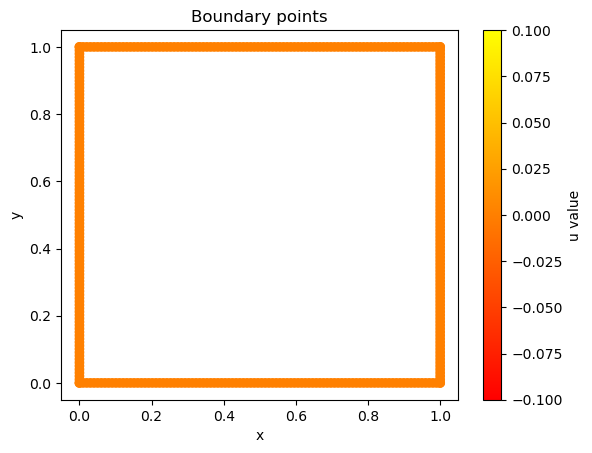

In [6]:
plt.scatter(x_boundary[:,0].detach().numpy(), x_boundary[:,1].detach().numpy(), c=u_boundary.detach().numpy(), cmap='autumn')
plt.colorbar(label='u value')
plt.title("Boundary points")
plt.xlabel("x")
plt.ylabel("y")

In [7]:
# define network architecture
input_dim = 2
output_dim = 1
num_hidden = 300

class Net(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, output_dim),
        )
        
        # Apply Kaiming initialization to the layers
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        y_out = self.linear_relu_stack(x)
        return y_out
    
net = Net(num_hidden)
    
# hyperparameters
learning_rate = 1e-3
batch_size = 20
num_epochs = 120

#initialize lambdas for soft-adaptation
lambda_pde = torch.nn.Parameter(torch.tensor([1.0], requires_grad=True))
lambda_bc = torch.nn.Parameter(torch.tensor([1.0], requires_grad=True))

#optimizer: weights updates the net, pde and bc update the lambda for soft-adaptation
optimizer_weights = optim.Adam(net.parameters(), lr=learning_rate)
optimizer_pde = optim.Adam([lambda_pde], lr=learning_rate)
optimizer_bc = optim.Adam([lambda_bc], lr=learning_rate)

Epoch 1 : Total loss 0.204615 , Pde loss: 0.140327 , Pde lambda: 1.024178 , Bc loss: 0.062818 , Bc lambda: 1.017132
Epoch 6 : Total loss 0.001114 , Pde loss: 0.000923 , Pde lambda: 1.035657 , Bc loss: 0.000156 , Bc lambda: 1.020009
Epoch 11 : Total loss 0.000998 , Pde loss: 0.000681 , Pde lambda: 1.041774 , Bc loss: 0.000283 , Bc lambda: 1.022552
Epoch 16 : Total loss 0.008735 , Pde loss: 0.005523 , Pde lambda: 1.049015 , Bc loss: 0.00289 , Bc lambda: 1.027435
Epoch 21 : Total loss 0.000664 , Pde loss: 0.000437 , Pde lambda: 1.053136 , Bc loss: 0.000198 , Bc lambda: 1.031554
Epoch 26 : Total loss 0.000823 , Pde loss: 0.000502 , Pde lambda: 1.065396 , Bc loss: 0.000277 , Bc lambda: 1.042426
Epoch 31 : Total loss 0.009116 , Pde loss: 0.005969 , Pde lambda: 1.077667 , Bc loss: 0.002611 , Bc lambda: 1.05012
Epoch 36 : Total loss 0.000284 , Pde loss: 0.000122 , Pde lambda: 1.081556 , Bc loss: 0.000144 , Bc lambda: 1.055039
Epoch 41 : Total loss 0.000132 , Pde loss: 6.6e-05 , Pde lambda: 1.0

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Loss'))

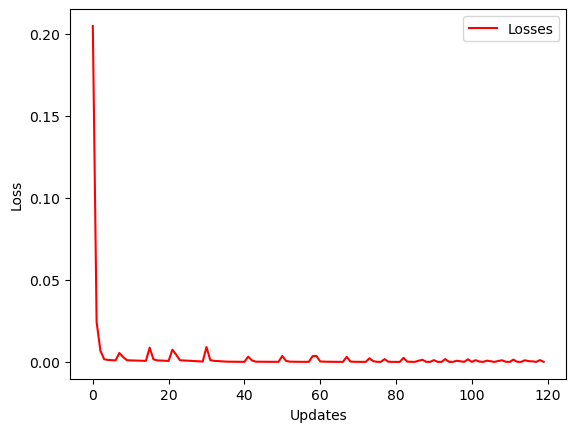

In [8]:
# train network

#getting epoch sizes
num_samples_train = x_interior.shape[0]
num_batches_train = num_samples_train // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
#test_acc, test_loss = [], []
cur_loss = 0
losses, pde_losses, bc_losses = [], [], []

get_slice = lambda i, size: range(i * size, (i + 1) * size) #get slices for each batch

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    pde_loss = 0
    bc_loss = 0
    net.train()
    for i in range(num_batches_train):
        # Zero the gradients for all optimizers
        optimizer_weights.zero_grad()
        optimizer_pde.zero_grad()
        optimizer_bc.zero_grad()
        
        slce = get_slice(i, batch_size)
        output = net(x_interior[slce, :])

        # compute gradients given loss
        batch_loss_pde = loss_pde(net, x_interior, f)
        batch_loss_bc = loss_bc(net, x_boundary, u_boundary)
        batch_loss = lambda_pde * batch_loss_pde + lambda_bc * batch_loss_bc # with soft adaptation
        batch_loss.backward()
        #check if pde_loss has gradient
        assert any(param.grad is not None for param in net.parameters()) == True
        
        #maximize gradients of lambdas by inverting the gradient
        with torch.no_grad():
            lambda_pde.grad *= -1
            lambda_bc.grad *= -1
        
        #update net and lambdas
        optimizer_weights.step()
        optimizer_pde.step()
        optimizer_bc.step()

        cur_loss += batch_loss.detach().numpy()
        pde_loss += batch_loss_pde.detach().numpy()
        
        bc_loss += batch_loss_bc.detach().numpy()
    losses.append(cur_loss / batch_size)
    pde_losses.append(pde_loss / batch_size)
    bc_losses.append(bc_loss / batch_size)

    net.eval()

    if epoch % 5 == 0:
        print(
            f"Epoch {epoch+1} : Total loss {np.round(losses[-1].item(), decimals=6)} , "
            f"Pde loss: {np.round(pde_losses[-1].item(), decimals=6)} , "
            f"Pde lambda: {np.round(lambda_pde.item(), decimals=3)} , "
            f"Bc loss: {np.round(bc_losses[-1].item(), decimals=6)} , "
            f"Bc lambda: {np.round(lambda_bc.item(), decimals=3)}"
    )
        
        
epoch = np.arange(len(losses))
plt.figure()
plt.plot(epoch, losses, 'r')
plt.legend(['Losses'])
plt.xlabel('Updates'), plt.ylabel('Loss')

## Visualization

In [9]:
def net_get_u_for_grid(xi, yi):
    #flatten grid matrices
    x_flat = xi.flatten()
    y_flat = yi.flatten()
    #convert numpy arrays into tensors
    x_tensor = torch.from_numpy(x_flat).view(-1, 1)
    y_tensor = torch.from_numpy(y_flat).view(-1, 1)
    #concatenate to create input tensor for net
    x_input = torch.cat((x_tensor, y_tensor), 1)
    x_input = x_input.to(dtype=torch.float)
    #get ui from net and transform back into numpy grid
    u_flat = net(x_input)
    ui = u_flat.detach().numpy().reshape(100,100)
    return ui

#net_get_u_for_grid(xi, yi)

In [10]:
#predicted values for u by the trained net for the interior point    
u = net(x_interior).detach().numpy()

#interpolate data for visualization
x = x_interior[:,0].detach().numpy()
y = x_interior[:,1].detach().numpy()
xi = np.linspace(x_min, x_max, 100)
yi = np.linspace(y_min, y_max, 100)
xi, yi = np.meshgrid(xi, yi)
ui = net_get_u_for_grid(xi, yi)
#ui = griddata((x, y), u, (xi, yi), method='cubic')

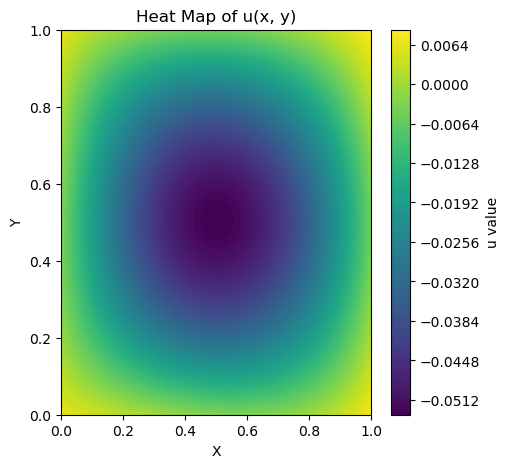

In [11]:
plt.figure(figsize=(5, 5))
plt.contourf(xi, yi, ui, 100, cmap='viridis')
plt.colorbar(label='u value')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Heat Map of u(x, y)')
plt.show()